# <center>ECE1724 - Project Implementation</center>
### <center>Team 1 - Multi-criteria optimal routing</center>
**<center>Agasti Kishor Dukare | Student ID: 1005602019</center>**
**<center>Qingqing Zhou | Student ID: 1003782463</center>**
**<center>Yunyi Zhu  | Student ID: 1002079252</center>**

In [2]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import poi as p
from common import *
from problem import *
import copy
from tqdm import tqdm
import itertools, heapq, random

## Prepare data
### 1. Load osm data

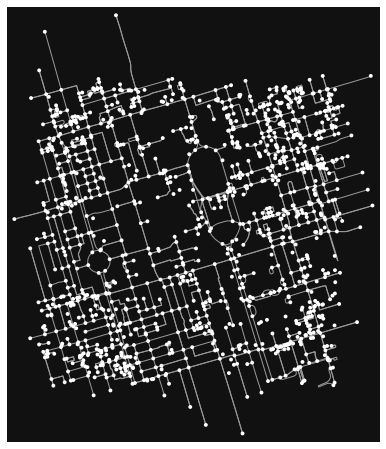

In [3]:
# load the osm data from overpass turbo into osmnx
G1 = ox.graph_from_xml("./data/uoft-highway-factors-fixed.osm", retain_all = True)
# plot the graph
fig, ax = ox.plot_graph(G1)

### 2. Add attributes for cost calculation and optimization

  - __travel_time__: calculated by distance/road_speed_limit

In [4]:
# Getting geopandas data frames to have a data structure representing the nodes and the ways in the graph
nodes, edges =  ox.graph_to_gdfs(G1)

list_travel_time = list()
for index, row in edges.iterrows():
    max_speed = 0.0
    if type(row.maxspeed)!=list:
        max_speed = float(row.maxspeed)
    else:
        max_speed = float(min(row.maxspeed))
        
    # typically NaN for highway=service or highway=residential
    # in this case set to 30.0 for now, subject to change
    if max_speed is np.nan:
        max_speed = 30.0
    
    # length is in meter; max_speed is km/h
    # travel time will be represented in seconds for each edge
    list_travel_time.append((row.length * 3600.0)/(max_speed * 1000))

- __num_traffic_signals__: the number of traffic signals belong to this edge/road (a traffic signal will be assgined to its closest road)

In [5]:
nodes_hw = nodes.dropna(subset=['highway'])
nodes_traffic_signals = nodes_hw[nodes_hw.highway=="traffic_signals"]

dict_traffic_signals = dict()
for index, node in nodes_traffic_signals.iterrows():
    nearest_edge = ox.get_nearest_edge(G1, (node.y, node.x))
    if nearest_edge not in dict_traffic_signals:
        dict_traffic_signals[nearest_edge] = 0
    dict_traffic_signals[nearest_edge] += 1

  - __num_bus_stop__: the number of bus stops belong to this edge/road (a bus stop will be assgined to its closest road)

In [6]:
nodes_bus_stop = nodes_hw[nodes_hw.highway=="bus_stop"]
dict_bus_stop = dict()
for index, node in nodes_bus_stop.iterrows():
    nearest_edge = ox.get_nearest_edge(G1, (node.y, node.x))
    if nearest_edge not in dict_bus_stop:
        dict_bus_stop[nearest_edge] = 0
    dict_bus_stop[nearest_edge] += 1

  - __shop__: identify if a specific node is a shop, such as coffee shop or grocery store. Shop will be used as a soft contraint. A route has to be either pass a shop (any shop) or clost to a shop.

In [7]:
# generate random integer values
from random import seed
from random import randint

# can be used to randomly select nodes to be the shops
def pick_random_nodes(nodes, count):
    # generate some integers
    picked_nodes = list()
    for _ in range(10):
        picked_nodes.append(randint(0, len(nodes)))

    return [nodes.iloc[node].osmid for node in picked_nodes]

In [8]:
# add shops to the dataset
shops_osmid = [344474254, 2439311265, 835057395, 2485312016, 49625951, 246693686, 835056613, 577453641, 1721866215, 2725510675]

nodes['shop'] = [True if index in shops_osmid else False for index, _ in nodes.iterrows()]

In [9]:
# form the updated graph 
edges['travel_time'] = list_travel_time
edges['num_traffic_signals'] = [dict_traffic_signals[(row.u, row.v, row.key)] if (row.u, row.v, row.key) in dict_traffic_signals else 0 for index, row in edges.iterrows()]
edges['num_bus_stop'] = [dict_bus_stop[(row.u, row.v, row.key)] if (row.u, row.v, row.key) in dict_bus_stop else 0 for index, row in edges.iterrows()]


G2 = ox.graph_from_gdfs(nodes, edges)

In [10]:
nodes, edges =  ox.graph_to_gdfs(G2)

### 3. Select source and destination nodes

In [11]:
# define source and destination
source = 580005380
dest = 26007926

#### plot the graph with source, destination and shops nodes
 - source and destination are in __red__
 - shops are in __yellow__

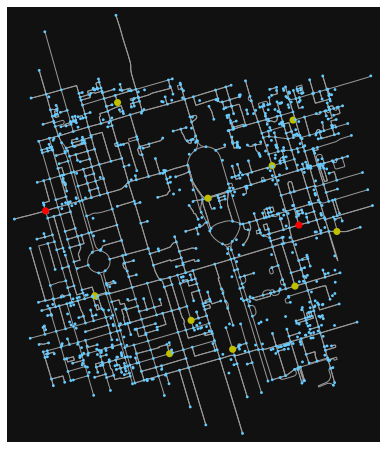

In [12]:
# plot the graph with source, destination and shops
highlighted = [source, dest]

nc = list()
ns = list()
for node in G2.nodes():
    if node in highlighted:
        nc.append('r')
        ns.append(50)
    elif node in shops_osmid:
        nc.append('y')
        ns.append(50)
    else:
        nc.append('#66ccff')
        ns.append(8)

fig, ax = ox.plot_graph(G2, node_size=ns, node_color=nc, node_zorder=2)

## Helper functions

In [13]:
import matplotlib.pyplot as plt

def plot_iteration_states(states, states_text, x_text, y_text, title):
    plt.xlabel(x_text)
    plt.ylabel(y_text)
    for state, text in zip(states, states_text):
        plt.plot(state, label = text)
    plt.title(title)
    plt.legend()
    plt.show()


# overall cost function
def cost_all(G, cost_func, route, ks, keys, orders, include_shop = False):
    if include_shop:
        return cost_func(G, route, ks, keys, orders) + route_shop_dist(route, shops_osmid)[0]
    else:
        return cost_func(G, route, ks, keys, orders)


def get_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    
    sorted_list = sorted([[i, Xs[i], Ys[i]] for i in range(len(Xs))], key=lambda cost: cost[1], reverse=maxY)
    pareto_front = [sorted_list[0]]
    
    for pair in sorted_list[1:]:
        if maxY:
            if pair[2] >= pareto_front[-1][2]:
                pareto_front.append(pair)
        else:
            if pair[2] <= pareto_front[-1][2]:
                pareto_front.append(pair)
    
    return pareto_front

def plot_pareto_frontier(Xs, Ys, pareto_front):
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[1] for pair in pareto_front]
    pf_Y = [pair[2] for pair in pareto_front]
    plt.plot(pf_X, pf_Y, 'r')
    plt.xlabel("Distance Cost (m)")
    plt.ylabel("Time Cost (s)")
    plt.show()


# calculate distance cost and time cost
def process_pareto(G, routes, include_shop=True):
    
    ks = [1, 0.1, 0.5]
    keys_dist = ['length', 'num_traffic_signals', 'num_bus_stop']
    keys_time = ['travel_time', 'num_traffic_signals', 'num_bus_stop']
    orders=[1, 1, 1]
    
    routes_dist = list()
    routes_time = list()
    
    for route in routes:
        routes_dist.append(cost_all(G, cost_with_constraints, route, ks, keys_dist, orders, include_shop))
        routes_time.append(cost_all(G, cost_with_constraints, route, ks, keys_time, orders, include_shop))
    
    frontiers = list()
    frontiers = get_pareto_frontier(routes_dist, routes_time, maxX=False, maxY=False)
    
    return routes_dist, routes_time, frontiers

In [14]:
def point_to_route_distance(route, point):
    
    dist = np.inf
    
    for node in route:
        tmp_dist = haversine_distance(
            nodes.x[nodes.osmid == point], nodes.y[nodes.osmid == point],
            nodes.x[nodes.osmid == node], nodes.y[nodes.osmid == node])
        
        if tmp_dist < dist:
            dist = tmp_dist

    return dist


def route_shop_dist(route, shops):
    
    dist_shop = np.inf
    best_shop = 0
    
    for shop in shops:
        if shop in route:
            return 0, shop
        else:
            dist = point_to_route_distance(route, shop)
            if dist < dist_shop:
                dist_shop = dist
                best_shop = shop
    
    return dist_shop, best_shop


In [15]:
def plot_routes(G, routes):
    # generate a set of randomized routes to start with
    RGBA_options = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    route_colors = list()
    num_routes = len(routes)
    
    for i in tqdm(range(num_routes)):
        route_colors.append(RGBA_options[i%len(RGBA_options)])
    
    fig, ax = ox.plot_graph_routes(G, routes, route_colors=route_colors)

## Design Adaptive methods

### 1. Use Tabu List to prevent using the same route while exploring

1. Generate a hash for a route in order to identify the route
1. Add the route hash to the Tabu list (a set)
1. Each item in Tabu list will be updated each iteration:
   - Tabu List maintains a list of routes that have been explored
   - routes in the Tabu List are ordered by exploring frequency
   - Tabu List size can be set as population size or the number of swarm particles
   - when Tabu List is full, the route with lease exploring frequency will be deleted
1. Whenever a new route being introduced, it must not exist in the tabu list

In [16]:
def generate_hash_route(route):
    return abs(hash(str(route))) % (10 ** 8)  # 8 digits long hash

def generate_route_tabu(G, source, dest, tabu_list):
    # generate initial route
    route = randomized_search(G, source, dest)
    route_hash = generate_hash_route(route)
    # check route in tabu list
    while route_hash in tabu_list:
        route = randomized_search(G, source, dest)
        route_hash = generate_hash_route(route)
    
    return route, route_hash

def is_route_in_tabu(route, tabu_list):
    route_hash = generate_hash_route(route)
    # check route in tabu list
    if route_hash in tabu_list:
        return True
    else:
        return False

def add_to_tabu_list(tabu_list, route, max_size):
    tabu_list.append(generate_hash_route(route))
    
    while len(tabu_list) > max_size:
        # delete the oldest route
        tabu_list.pop(0)

In [17]:
hash_routes = dict()
tabu_list = list()

# generate hash for each route
for i in range(3):
    route = randomized_search(G2, source, dest)
    hash_routes[generate_hash_route(route)] = route

# check if hash matches for the same route
i = 0
for k, v in hash_routes.items():
    if k == generate_hash_route(v):
        print(*['route', i, 'matches'])
    else:
        print(*['route', i, 'doesn\'t matches'])
    i = i + 1
    
    # Add route to the tabu list
    tabu_list.append(k)

route 0 matches
route 1 matches
route 2 matches


In [18]:
# generate new route which shouldn't belong to tabu list
route, route_hash = generate_route_tabu(G2, source, dest, tabu_list)
if route_hash in tabu_list:
    print("Generated route already exists in Tabu List")
else:
    print("Generated route doesn't exist in Tabu List")

Generated route doesn't exist in Tabu List


In [19]:
# add a new route to tabu list with maximum elements in tabu list is 3 routes
origin_list = copy.deepcopy(tabu_list)
add_to_tabu_list(tabu_list, route, 3)

# show origin and new tabu list
print(origin_list)
print(tabu_list)

[9803791, 81507903, 16294059]
[81507903, 16294059, 39829775]


### 2. Determine the probability of exploring new route

1. When close to the beginning of the iterations, algorithm will emphasize on _diversification_ 
1. When close to the end of the iterations, algorithm will emphasize on _intensification_ and aim to converge 
1. Therefore, we need a function of probabilities to give
   - high probabilities on introducing new routes at the beginning of the search
   - low probabilities on introducing new routes closing to the end of the search
1. One possible function can be as below: (modified from sigmoid function)

$f(x) = \frac{1}{1+e^{0.4(x-\frac{Total\ Iterations}{2})}} $

The plot is diaplyed as below:
- starting from probability = 1 at the beginning
- probabilities dropping to half (50%) in the middle of the entire iterations
- probabilites fall close to 0% at the end of the entire iterations

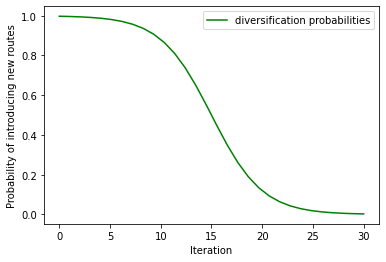

In [20]:
import matplotlib.pyplot as plt

# Assume 30 iterations
x = np.linspace(0,30,30)

# the probability function
y = 1 / (1 + np.exp(0.4*(x-30/2)))

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'y', label='diversification probabilities', color='g')
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("Probability of introducing new routes")
    
# show the plot
plt.show()

#### Define the function to get the probability according to the current iteration

In [21]:
import matplotlib.pyplot as plt

def get_extend_probability(cur_iteration, total_iteration, dropping_slope = 0.4, init_prob = 1):
    return init_prob / (1 + np.exp(dropping_slope * (cur_iteration - total_iteration/2)))

In [22]:
# Test function: assume we have 30 iterations in total, currently running the 15th itertaion
get_extend_probability(15, 30)

0.5

### 3. When to introduce new routes over mutation of existing routes

- When local best is not improving the global solution for certain iterations
- The threshold of non-improving iterations can be determined by inversing `get_extend_probability()`

   __Non-improving iterations threshold = min_iterations + (Total Iterations / 5) * (1 - _get_extend_probability()_)__
   
   
- When `non-improving iterations threshold` reaches:
   - explore new routes by random generation
   - newly generated new route must not exist in the Tabu List
   - the number of new routes will be determined by `get_extend_probability()`

In [23]:
def get_non_improving_iterations_threshold(cur_iteration, total_iteration,
                                           min_threshold = 2, dropping_slope = 0.4, init_prob = 1):
    return min_threshold + (total_iteration / 5) * \
           (1 - get_extend_probability(cur_iteration, total_iteration, dropping_slope, init_prob))

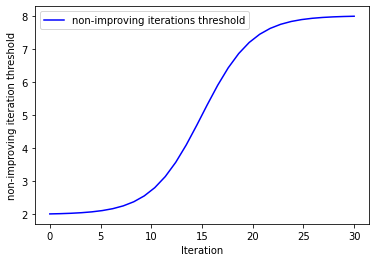

In [24]:
# Assume 30 iterations
total_iterations = 30

x = np.linspace(0, total_iterations, total_iterations)

# plot the non-improving iterations thresholds
# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x, get_non_improving_iterations_threshold(x, total_iterations),
         'y', label='non-improving iterations threshold', color='b')
plt.legend(loc='upper left')
plt.xlabel("Iteration")
plt.ylabel("non-improving iteration threshold")

# show the plot
plt.show()

In [25]:
print("For total 30 iterations, when at iteration 2, it requires " + str(int(get_non_improving_iterations_threshold(2, total_iterations))) +
     " non-improving iterations to trigger the new route exploration")
print("For total 30 iterations, when at iteration 15, it requires " + str(int(get_non_improving_iterations_threshold(15, total_iterations))) +
     " non-improving iterations to trigger the new route exploration")
print("For total 30 iterations, when at iteration 29, it requires " + str(int(get_non_improving_iterations_threshold(29, total_iterations))) +
     " non-improving iterations to trigger the new route exploration")

For total 30 iterations, when at iteration 2, it requires 2 non-improving iterations to trigger the new route exploration
For total 30 iterations, when at iteration 15, it requires 5 non-improving iterations to trigger the new route exploration
For total 30 iterations, when at iteration 29, it requires 7 non-improving iterations to trigger the new route exploration


### 4. How to introduce new routes to existing routes

- Use `get_extend_probability()` to determine the percentage of the new routes we should introduce
- Maximum new routes is half of the total routes

   __# of new routes = (Total Routes / 2) * _get_extend_probability()___
 
   _P.S. total routes can be total population or total number of swarm particles_

In [26]:
def get_num_new_routes(total_routes, cur_iteration, total_iteration, dropping_slope = 0.4, init_prob = 1):
    return (total_routes / 2) * get_extend_probability(cur_iteration, total_iteration, dropping_slope, init_prob)

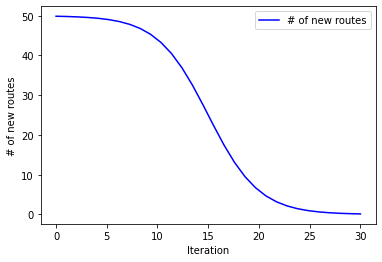

In [27]:
# Assume 30 iterations with total 100 routes
total_iterations = 30
total_routes = 100

x = np.linspace(0, total_iterations, total_iterations)

# plot the non-improving iterations thresholds
# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x, get_num_new_routes(total_routes, x, total_iterations),
         'y', label='# of new routes', color='b')
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("# of new routes")

# show the plot
plt.show()

In [28]:
print("For total 30 iterations and 100 routes, when at iteration 2, it will generate " + 
      str(int(get_num_new_routes(total_routes, 2, total_iterations))) + " new routes")
print("For total 30 iterations and 100 routes, when at iteration 15, it will generate " +
      str(int(get_num_new_routes(total_routes, 15, total_iterations))) + " new routes")
print("For total 30 iterations and 100 routes, when at iteration 29, it will generate " +
      str(int(get_num_new_routes(total_routes, 29, total_iterations))) + " new routes")

For total 30 iterations and 100 routes, when at iteration 2, it will generate 49 new routes
For total 30 iterations and 100 routes, when at iteration 15, it will generate 25 new routes
For total 30 iterations and 100 routes, when at iteration 29, it will generate 0 new routes


## Genetic Algorithm with Adaptive 

1. Randomly generately the initial population
1. Run through Genetic Algorithm with below configuration
   - Number of Population: 8 routes
   - Number of Generation: 10
   - Number of Parents: 4
1. Apply __adaptive methods__ for exploration
   - parents who have been explored from previous iteration will be added to Tabu list
   - when close to the beginning, we require most of the parents are not in the Tabu list
   - when close to the end, we allow most of the parents from Tabu list

### 1. Prepare GA and Adaptive functions

In [29]:
def generate_new_routes_tabu(G, source, dest, tabu_list, num_routes):
    # generate new routes
    new_routes = list()
    for i in range(num_routes):
        route, _ = generate_route_tabu(G, source, dest, tabu_list)
        # add to new routes
        new_routes.append(route)

    return new_routes


def adaptive_process(G, routes, source, dest, tabu_list, non_improving_cnt,
                     total_routes, current_iteration, total_iterations):
    # no need to generate new route
    if non_improving_cnt < get_non_improving_iterations_threshold(current_iteration, total_iterations):
        return
    
    # generate new routes
    new_routes = generate_new_routes_tabu(G, source, dest, tabu_list, 
                                          int(get_num_new_routes(total_routes, current_iteration, total_iterations)))
    
    if len(new_routes) > 0:
        # print("Add "+ str(len(new_routes)) + " new routes")
        routes = routes + new_routes
        while len(routes) > total_routes:
            #print("delete old route")
            routes.pop(0)


def adaptive_parents(G, parents, source, dest, tabu_list, total_routes, current_iteration, total_iterations):
    
    max_cnt_new_routes = int(get_num_new_routes(total_routes, current_iteration, total_iterations))
    
    cnt = 0
    i = 0
    for parent in parents:
        if is_route_in_tabu(parent, tabu_list):
            if cnt < max_cnt_new_routes:
                parents.pop(i)
                cnt = cnt + 1
    
    # generate new routes
    new_routes = generate_new_routes_tabu(G, source, dest, tabu_list, cnt)
    return parents + new_routes

In [30]:
# a wrapper function to do GA with user defined cost function
def genetic_algorithm(G, cost_func, ks, keys, orders, include_shop = False, 
                      num_population = 8, num_generations = 10, num_parents = 4):
    
    routes = list()
    tabu_list = list()

    # generate a set of randomized routes to start with
    # routes = generate_new_routes_tabu(G, source, dest, tabu_list, num_population)
    temp_tabu_list = list()
    while len(routes) < num_population:
        route = generate_new_routes_tabu(G, source, dest, temp_tabu_list, 1)[0]
        routes.append(route)
        add_to_tabu_list(temp_tabu_list, route, num_population * num_generations)
        
    itr_costs = dict()
    # collect info for initial status
    itr_costs['0'] = list()
    for route in routes:
        itr_costs['0'].append(cost_all(G, cost_func, route, ks, keys, orders, include_shop))
        
    global_states = list()
    local_states = list()
        
    local_best_routes = list()
    local_best_cost = np.inf
    
    global_best_route = list()
    global_best_cost = local_best_cost

    local_states.append(local_best_cost)
    global_states.append(global_best_cost)
    
    non_improving_cnt = 0
    
    # print("GA: initialization done")

    for generation in tqdm(range(num_generations)):
        # user defined cost function
        costs = [cost_all(G, cost_func, route, ks, keys, orders, include_shop) for route in routes]
        
        # convert cost to probability distance for select_best
        prob_dist = [1/x for x in costs]
        
        # this is a roulette wheel selection from problem.py
        parents_1 = select_best(routes, num_parents, prob_dist)
        
        parents_1 = adaptive_parents(G, parents_1, source, dest, tabu_list, num_population, generation, num_generations)
        #print("len=", len(parents_1))        
        
        # add parents_1 to tabu list
        for route in parents_1:
            add_to_tabu_list(tabu_list, route, num_population * num_generations)
        
        # naive cross_over() from problem.py that only recombines when there are intersections
        # TODO: replace it with better cross_over algorithms
        parents_2 = [cross_over(route_1, route_2) for route_1, route_2 in itertools.product(parents_1, repeat = 2)]
        parents_2 = heapq.nsmallest(num_parents, parents_2, key = lambda route : 
                                    cost_all(G, cost_func, route, ks, keys, orders, include_shop))
        
        # TODO: could replace mutate() with other mutation implementation
        parents = [mutate(G, route) for route in parents_2]
        
        # a local search on the neighbours using the children_route() implementation from common.py
        # generate the offspring of these parents -- each parent will generate 15/3=5 children
        # for 3 parents in total, we will generate a set of 15 routes which maintains the same pool size
        routes = flatten([[*itertools.islice(children_route(G, route), num_population // num_parents)] for route in parents])
        
        # remove duplicates
        routes = [*map(list, list(set(map(tuple, routes))))]
                
        # see how many routes have been removed and fill the routes with random ones til the number num_population
        num_removed = num_population - len(routes)
        #routes.extend([randomized_search(G, source, dest) for _ in range(num_removed)])
        if num_removed > 0:
            routes = routes + generate_new_routes_tabu(G, source, dest, tabu_list, num_removed)
        
        # collect info for this iteration
        itr_costs['G'+str(generation)] = list()
        for route in routes:
            itr_costs['G'+str(generation)].append(cost_all(G, cost_func, route, ks, keys, orders, include_shop))
                
        # to track the best route at each iteration
        local_best_route = min(routes, key = lambda route : 
                               cost_all(G, cost_func, route, ks, keys, orders, include_shop))
        local_best_cost = cost_all(G, cost_func, local_best_route, ks, keys, orders, include_shop)
        if local_best_cost < global_best_cost:
            global_best_route = copy.deepcopy(local_best_route)
            global_best_cost = local_best_cost
            non_improving_cnt = 0
            add_to_tabu_list(tabu_list, local_best_route, num_population * num_generations)
        else:
            non_improving_cnt = non_improving_cnt + 1
        
        local_best_routes.append(local_best_route)
        local_states.append(local_best_cost)
        global_states.append(global_best_cost)
        
        # apply adaptation
        adaptive_process(G, routes, source, dest, tabu_list, non_improving_cnt, num_population, generation, num_generations)
        
    return local_best_routes, global_best_route, local_states, global_states, itr_costs

### 2. Run Genetic Algorithm with adaptive control

#### Case 1: Use criteria `Distance of a route`

$cost = \sum_{edges}{edge[length]} + constraints$

In [223]:
# Run several times
cnt_runs = 5
GA_local_best_routes_dist = list()
GA_global_best_route_dist = list()
GA_local_states_dist = list()
GA_global_states_dist = list()
GA_itr_costs_dist = list()

for i in tqdm(range(5)):
    local_best_routes, global_best_route, local_states, global_states, itr_costs = genetic_algorithm(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)
    
    GA_local_best_routes_dist.append(local_best_routes)
    GA_global_best_route_dist.append(global_best_route)
    GA_local_states_dist.append(local_states)
    GA_global_states_dist.append(global_states)
    GA_itr_costs_dist.append(itr_costs)

100%|██████████| 5/5 [15:03<00:00, 180.67s/it]


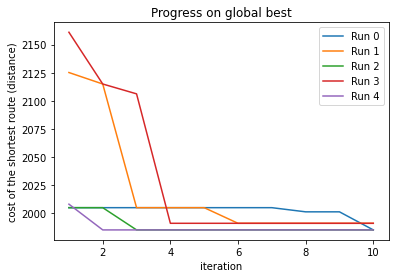

In [224]:
# the progress of global best across several runs
legend_text = list()
for i in range(len(GA_global_states_dist)):
    legend_text.append('Run ' + str(i))

plot_iteration_states(GA_global_states_dist, legend_text, 'iteration',
                      'cost of the shortest route (distance)', 'Progress on global best')

In [233]:
itr_costs_df_dist = pd.DataFrame(GA_itr_costs_dist[4])
itr_costs_df_dist

,0,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9
0,2144.711888,2477.861980,2477.861980,2477.861980,2351.006947,2114.969036,2352.730947,2477.861980,2477.861980,2477.861980,2352.730947
1,2371.219426,2352.730947,2114.969036,2352.730947,2114.969036,2334.713690,2477.861980,2114.969036,2352.730947,2114.969036,2353.291947
2,2161.395888,2368.998986,2334.713690,2106.208888,2476.137980,2753.233986,2114.969036,2334.713690,2372.219426,2334.713690,2478.422980
3,2187.660888,2293.844986,2352.730947,2236.549888,2334.713690,2281.621673,2334.713690,2352.730947,2527.036947,2352.730947,2334.713690
4,2371.899426,2193.703980,2466.963426,2819.927036,2753.368986,2223.343888,2161.619888,2119.644980,2412.307986,2452.949947,2477.861980
5,2846.341000,2416.888426,1985.237986,2368.998986,2700.633986,2124.772888,2397.108986,2125.177888,2119.244980,2293.439986,2114.969036
6,2005.017426,2008.130426,2624.069888,2769.858507,2161.395888,2119.244980,2471.918947,2293.844986,2293.439986,2657.587986,2865.415000
7,2008.130426,2310.142000,2293.844986,3007.415426,2696.828947,2221.060986,2293.844986,2803.714426,2397.664986,2368.749426,2468.519426


<AxesSubplot:title={'center':'population costs (distance) through generations'}>

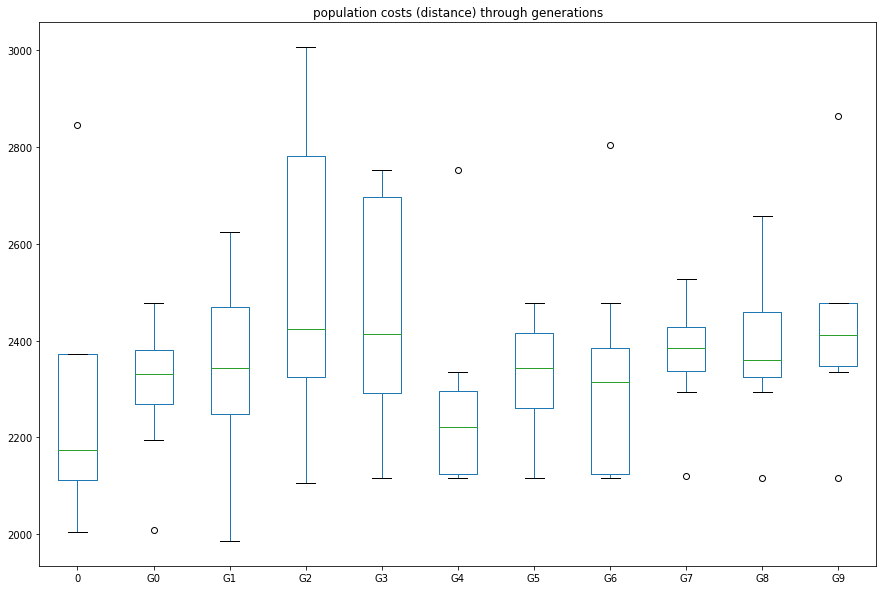

In [234]:
itr_costs_df_dist.plot.box(title="population costs (distance) through generations", figsize=(15,10))

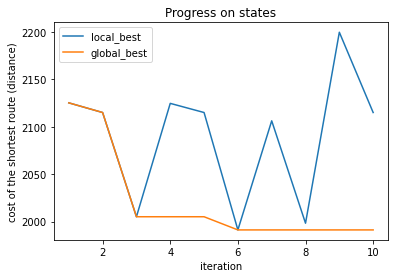

In [238]:
# the progress of the cost from both local and global best
plot_iteration_states([GA_local_states_dist[1], GA_global_states_dist[1]], ['local_best', 'global_best'], 'iteration', 'cost of the shortest route (distance)', 'Progress on states')

100%|██████████| 5/5 [00:00<00:00, 20340.95it/s]


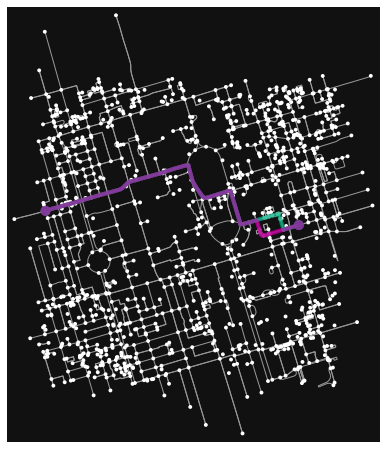

In [236]:
plot_routes(G2, GA_global_best_route_dist)

#### Case 2. Use criteria `Travel Time of a route`

$cost = \sum_{edges}{edge[travel\_time]} + constraints$

In [239]:
# use time cost
#GA_local_best_routes_time, GA_global_best_route_time, GA_local_states_time, GA_global_states_time, GA_itr_costs_time, GA_itr_routes_time = genetic_algorithm(
#    G2, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)


# Run several times
cnt_runs = 5
GA_local_best_routes_time = list()
GA_global_best_route_time = list()
GA_local_states_time = list()
GA_global_states_time = list()
GA_itr_costs_time = list()

for i in tqdm(range(5)):
    local_best_routes, global_best_route, local_states, global_states, itr_costs = genetic_algorithm(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)
    
    GA_local_best_routes_time.append(local_best_routes)
    GA_global_best_route_time.append(global_best_route)
    GA_local_states_time.append(local_states)
    GA_global_states_time.append(global_states)
    GA_itr_costs_time.append(itr_costs)

100%|██████████| 5/5 [15:18<00:00, 183.64s/it]


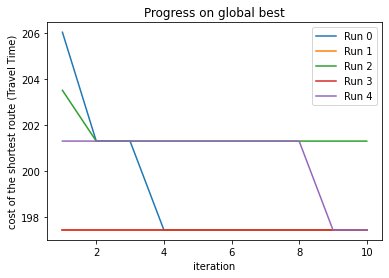

In [240]:
# the progress of global best across several runs
legend_text = list()
for i in range(len(GA_global_states_time)):
    legend_text.append('Run ' + str(i))

plot_iteration_states(GA_global_states_time, legend_text, 'iteration',
                      'cost of the shortest route (Travel Time)', 'Progress on global best')

In [244]:
itr_costs_df_time = pd.DataFrame(GA_itr_costs_time[1])
itr_costs_df_time

,0,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9
0,256.670360,219.363553,219.313063,219.313063,240.689546,201.317054,240.689546,240.689546,219.313063,201.317054,240.689546
1,212.290138,240.740036,240.689546,219.363553,222.448653,240.740036,201.317054,219.313063,240.689546,227.684348,222.448653
2,230.034428,201.317054,201.317054,240.740036,243.825136,219.363553,227.684348,249.623236,201.317054,256.670360,243.825136
3,339.151974,227.684348,227.684348,227.684348,219.313063,227.684348,219.313063,241.221578,227.684348,220.190548,219.313063
4,244.910198,199.981209,233.321168,240.689546,213.924888,254.835636,212.138988,208.644896,257.809510,258.262960,220.190548
5,203.267949,253.243036,270.706436,201.317054,273.553680,307.381454,244.035908,253.203116,207.523356,235.852518,214.167490
6,290.865878,252.885417,273.756338,242.266658,300.240989,207.896916,275.234266,271.580899,207.292996,277.319298,208.644896
7,330.031704,197.457746,263.034010,211.113726,226.732818,214.541050,254.006167,213.975378,231.284156,214.167490,215.119338


<AxesSubplot:title={'center':'population costs (travel time) through generations'}>

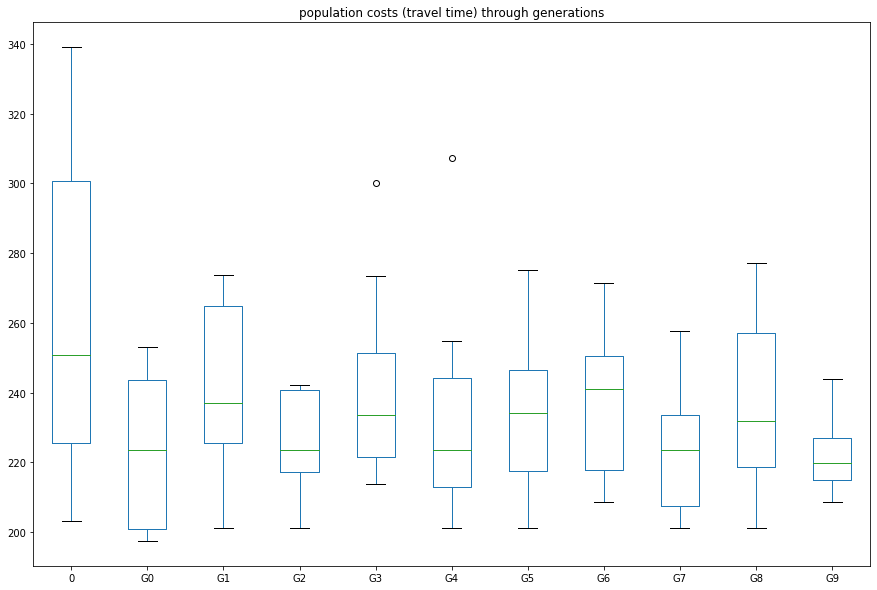

In [245]:
itr_costs_df_time.plot.box(title="population costs (travel time) through generations", figsize=(15,10))

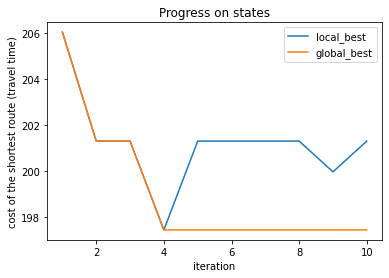

In [247]:
# the progress of the cost from both local and global best
plot_iteration_states([GA_local_states_time[0], GA_global_states_time[0]], ['local_best', 'global_best'], 'iteration', 'cost of the shortest route (travel time)', 'Progress on states')

100%|██████████| 5/5 [00:00<00:00, 35305.59it/s]


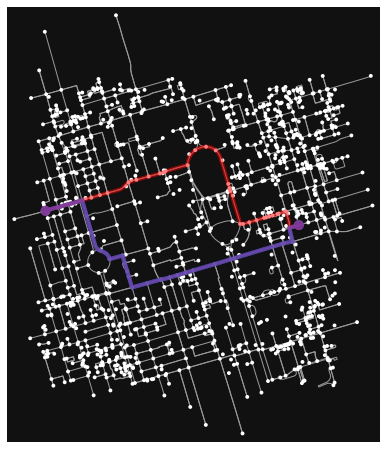

In [248]:
plot_routes(G2, GA_global_best_route_time)

#### Case 3: combine both `Distance` and `Travel Time`

collect all the local best on each iteration and plot pareto frontier

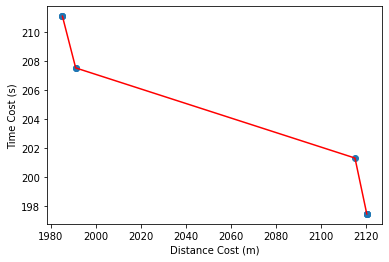

In [249]:
# get frontier
GA_route_candidates = GA_global_best_route_dist + GA_global_best_route_time
GA_routes_dist, GA_routes_time, GA_frontiers = process_pareto(G2, GA_route_candidates)

# plot frontier
plot_pareto_frontier(GA_routes_dist, GA_routes_time, GA_frontiers)

100%|██████████| 10/10 [00:00<00:00, 85250.08it/s]


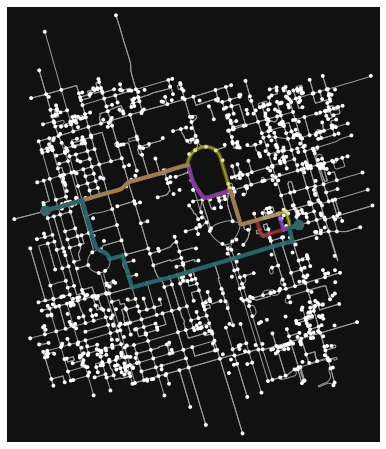

In [250]:
# display best solutions
GA_frontier_routes = list()

for front in GA_frontiers:
    GA_frontier_routes.append(GA_route_candidates[front[0]])

plot_routes(G2, GA_frontier_routes)

## Particle Swarm Optimization (PSO) with Adaptive methods

1. We will use the same dataset and source/destination nodes as for Genetic Algorithm
   - refer to `3. Select source and destination nodes`
1. Randomly generately the initial population
1. Run through __PSO__ with below configuration
   - Number of Particles in all swarms: 200 routes
   - Number of swarms: 4
   - Number of iterations: 50
1. Adaptive leaders
   - if the leader of each swarm has already existed in the Tabu list, this leader will be replaced
   - the number of leaders might be replaced is determined by the current iteration number and the total particles

### 1. Define PSO particles and swarms

In [31]:
# prepare the souce and destination nodes
origin_node = Node(graph = G2, osmid = source)
dest_node = Node(graph = G2, osmid = dest)

# configure PSO model
particles_swarm = 200
num_of_swarms = 4
num_of_iterations = 50

### 2. Run PSO with multi-crieria

In [32]:
def adaptive_leaders(G, leaders, num_of_swarms, tabu_list, total_routes, current_iteration, total_iterations):
    
    max_cnt_new_routes = int(get_num_new_routes(total_routes, current_iteration, total_iterations))
    
    valid_leaders = leaders[:num_of_swarms][:]
    #print("len of valid=", len(valid_leaders))
    
    cnt = 0
    i = 0
    for leader in valid_leaders:
        if is_route_in_tabu(leader, tabu_list):
            if cnt < max_cnt_new_routes:
                valid_leaders.pop(i)
                cnt = cnt + 1
    
    # generate new routes
    new_routes = generate_new_routes_tabu(G, source, dest, tabu_list, cnt)
    valid_leaders = valid_leaders + new_routes
    
    i = 0
    for leader in valid_leaders:
        leaders[i] = leader
        i = i + 1


def add_new_leaders(leaders, particles, num_of_swarms, swarm_particles, tabu_list):
    
    new_leaders = list()
    i = 0
    for leader in leaders:
        if not is_route_in_tabu(leader, tabu_list):
            new_leaders.append(leader)
            i = i + 1
            if i >= num_of_swarms:
                break
    
    i = 0
    for leader in new_leaders:
        particles[i * swarm_particles] = leader
        i = i + 1
    
    while i < num_of_swarms:
        particles[i * swarm_particles] = leaders[i]
        i = i + 1

    
def pso(G, cost_func, ks, keys, orders, include_shop, particles_swarm = 15, num_of_swarms = 3, num_of_iterations = 20):
    
    particles = list()
    tabu_list = list()
    
    # generate a set of randomized routes to start with
    particles = generate_new_routes_tabu(G, source, dest, tabu_list, particles_swarm)
        
    global_states = list()
    local_states = list()
        
    local_best_routes = list()
    local_best_cost = np.inf
    
    global_best_route = list()
    global_best_cost = local_best_cost

    local_states.append(local_best_cost)
    global_states.append(global_best_cost)
    
    non_improving_cnt = 0
    
    for iteration in tqdm(range(num_of_iterations)):
        
        # we need to have `num_of_swarms` particles to lead
        # a swarm and be its lbest ... that changes every iteration
        particles.sort(key = lambda particle : 
                       cost_all(G, cost_func, particle, ks, keys, orders, include_shop))
        swarm_particles = particles_swarm // num_of_swarms
        
        leaders = particles[:swarm_particles][:]
        
        # make sure leaders in each swarm are not already in the Tabu list
        adaptive_leaders(G, leaders, num_of_swarms, tabu_list, particles_swarm, iteration, num_of_iterations)
        
        # add parents_1 to tabu list
        for i in range(num_of_swarms):
            add_to_tabu_list(tabu_list, leaders[i], particles_swarm)
            
        for i in range(num_of_swarms):
            particles[i] , particles[i * swarm_particles] = particles[i * swarm_particles], particles[i]
        
        swarms = list()
        
        for i in range(num_of_swarms):
            swarms.append(particles[i * (swarm_particles): i*(swarm_particles) + swarm_particles])
        
        # for each swarm follow the leader of the swarm
        def follow_leader_local(population):
            for i in range(1, len(population)):
                population[i] = cross_over(population[0], population[i]) # this is what we are doing
        
        for swarm in swarms:
            follow_leader_local(swarm)
        
        def follow_leader_global():
            for u, v in itertools.product(range(0, len(leaders)), range(0, len(leaders))):
                tobeMutated = random.choice([u, v])
                leaders[tobeMutated] = cross_over(leaders[u], leaders[v])
        
        follow_leader_global()
        
        # adding the new leaders
        add_new_leaders(leaders, particles, num_of_swarms, swarm_particles, tabu_list)
        
        # to track the best route at each iteration    
        local_best_route = min(particles, key = lambda particle : 
                               cost_all(G, cost_func, particle, ks, keys, orders, include_shop))
        local_best_cost = cost_all(G, cost_func, local_best_route, ks, keys, orders, include_shop)
        
        if local_best_cost < global_best_cost:
            global_best_route = copy.deepcopy(local_best_route)
            global_best_cost = local_best_cost
            non_improving_cnt = 0
        else:
            non_improving_cnt = non_improving_cnt + 1
        
        local_states.append(local_best_cost)
        local_best_routes.append(local_best_route)
        global_states.append(global_best_cost)
        
        # apply adaptation
        adaptive_process(G, particles, source, dest, tabu_list, non_improving_cnt, particles_swarm, iteration, num_of_iterations)
    
    return local_best_routes, global_best_route, local_states, global_states

#### Case 1: Use criteria `Distance of a route`

$cost = \sum_{edges}{edge[length]} + constraints$

In [335]:
# use distance cost
#GA_local_best_routes_time, GA_global_best_route_time, GA_local_states_time, GA_global_states_time, GA_itr_costs_time, GA_itr_routes_time = genetic_algorithm(
#    G2, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)


# Run several times
cnt_runs = 5
PSO_local_best_routes_dist = list()
PSO_global_best_route_dist = list()
PSO_local_states_dist = list()
PSO_global_states_dist = list()

for i in tqdm(range(5)):
    local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)
    
    PSO_local_best_routes_dist.append(local_best_routes)
    PSO_global_best_route_dist.append(global_best_route)
    PSO_local_states_dist.append(local_states)
    PSO_global_states_dist.append(global_states)

100%|██████████| 5/5 [14:47<00:00, 177.51s/it]


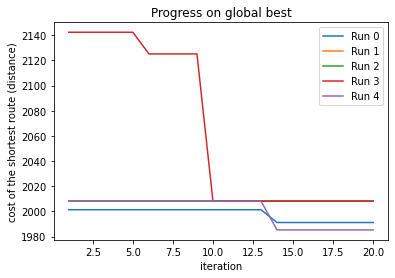

In [336]:
# the progress of global best across several runs
legend_text = list()
for i in range(len(PSO_global_states_dist)):
    legend_text.append('Run ' + str(i))

plot_iteration_states(PSO_global_states_dist, legend_text, 'iteration',
                      'cost of the shortest route (distance)', 'Progress on global best')

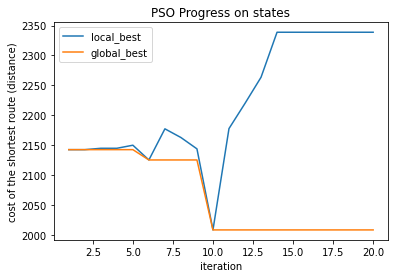

In [337]:
# the progress of the cost from both local and global best
plot_iteration_states([PSO_local_states_dist[3], PSO_global_states_dist[3]], ['local_best', 'global_best'], 'iteration', 'cost of the shortest route (distance)', 'PSO Progress on states')

100%|██████████| 5/5 [00:00<00:00, 8867.45it/s]


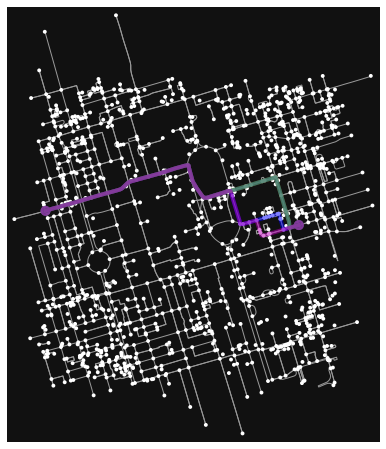

In [338]:
plot_routes(G2, PSO_global_best_route_dist)

#### Case 2. Use criteria `Travel Time of a route`

$cost = \sum_{edges}{edge[travel\_time]} + constraints$

In [328]:
# use time cost
#PSO_local_best_route_time, PSO_global_best_route_time, PSO_local_states_time, PSO_global_states_time = pso(
#    G2, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)

# Run several times
cnt_runs = 5
PSO_local_best_routes_time = list()
PSO_global_best_route_time = list()
PSO_local_states_time = list()
PSO_global_states_time = list()

for i in tqdm(range(5)):
    local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['travel_time', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True)
    
    PSO_local_best_routes_time.append(local_best_routes)
    PSO_global_best_route_time.append(global_best_route)
    PSO_local_states_time.append(local_states)
    PSO_global_states_time.append(global_states)

  0%|          | 0/20 [00:00<?, ?it/s]

====0= 0
====1= 0
====2= 3



  5%|▌         | 1/20 [00:08<02:50,  8.95s/it]

====0= 3
====1= 3
====2= 3



 10%|█         | 2/20 [00:17<02:38,  8.83s/it]

====0= 0
====1= 0
====2= 3



 15%|█▌        | 3/20 [00:25<02:27,  8.70s/it]

====0= 0
====1= 0
====2= 3



 20%|██        | 4/20 [00:34<02:18,  8.67s/it]

====0= 0
====1= 0
====2= 3



 25%|██▌       | 5/20 [00:43<02:09,  8.64s/it]

====0= 3
====1= 3
====2= 3



 30%|███       | 6/20 [00:52<02:02,  8.74s/it]

====0= 0
====1= 0
====2= 3



 35%|███▌      | 7/20 [01:00<01:53,  8.71s/it]

====0= 0
====1= 0
====2= 3



 40%|████      | 8/20 [01:09<01:44,  8.72s/it]

====0= 0
====1= 0
====2= 3



 45%|████▌     | 9/20 [01:18<01:36,  8.75s/it]

====0= 2
====1= 2
====2= 3



 50%|█████     | 10/20 [01:26<01:27,  8.72s/it]

====0= 0
====1= 0
====2= 3



 55%|█████▌    | 11/20 [01:35<01:19,  8.80s/it]

====0= 0
====1= 0
====2= 3



 60%|██████    | 12/20 [01:44<01:11,  8.88s/it]

====0= 0
====1= 0
====2= 3



 65%|██████▌   | 13/20 [01:53<01:02,  8.90s/it]

====0= 0
====1= 0
====2= 3



 70%|███████   | 14/20 [02:02<00:53,  8.87s/it]

====0= 0
====1= 0
====2= 3



 75%|███████▌  | 15/20 [02:11<00:43,  8.78s/it]

====0= 0
====1= 0
====2= 3



 80%|████████  | 16/20 [02:20<00:35,  8.78s/it]

====0= 0
====1= 0
====2= 3



 85%|████████▌ | 17/20 [02:28<00:26,  8.72s/it]

====0= 0
====1= 0
====2= 3



 90%|█████████ | 18/20 [02:37<00:17,  8.71s/it]

====0= 0
====1= 0
====2= 3



 95%|█████████▌| 19/20 [02:45<00:08,  8.63s/it]

====0= 0
====1= 0
====2= 3



  0%|          | 0/20 [00:00<?, ?it/s]

====0= 0
====1= 0
====2= 3



  5%|▌         | 1/20 [00:08<02:49,  8.92s/it]

====0= 3
====1= 3
====2= 3



 10%|█         | 2/20 [00:17<02:39,  8.84s/it]

====0= 3
====1= 3
====2= 3



 15%|█▌        | 3/20 [00:26<02:31,  8.91s/it]

====0= 3
====1= 3
====2= 3



 20%|██        | 4/20 [00:35<02:23,  8.95s/it]

====0= 0
====1= 0
====2= 3



 25%|██▌       | 5/20 [00:45<02:16,  9.12s/it]

====0= 3
====1= 3
====2= 3



 30%|███       | 6/20 [00:54<02:08,  9.21s/it]

====0= 0
====1= 0
====2= 3



 35%|███▌      | 7/20 [01:03<01:59,  9.15s/it]

====0= 0
====1= 0
====2= 3



 40%|████      | 8/20 [01:13<01:51,  9.27s/it]

====0= 1
====1= 1
====2= 3



 45%|████▌     | 9/20 [01:22<01:42,  9.32s/it]

====0= 3
====1= 3
====2= 3



 50%|█████     | 10/20 [01:31<01:32,  9.27s/it]

====0= 1
====1= 1
====2= 3



 55%|█████▌    | 11/20 [01:41<01:24,  9.34s/it]

====0= 0
====1= 0
====2= 3



 60%|██████    | 12/20 [01:50<01:14,  9.26s/it]

====0= 3
====1= 3
====2= 3



 65%|██████▌   | 13/20 [01:59<01:04,  9.27s/it]

====0= 0
====1= 0
====2= 3



 70%|███████   | 14/20 [02:08<00:55,  9.28s/it]

====0= 0
====1= 0
====2= 3



 75%|███████▌  | 15/20 [02:18<00:46,  9.22s/it]

====0= 0
====1= 0
====2= 3



 80%|████████  | 16/20 [02:27<00:37,  9.29s/it]

====0= 0
====1= 0
====2= 3



 85%|████████▌ | 17/20 [02:36<00:27,  9.26s/it]

====0= 0
====1= 0
====2= 3



 90%|█████████ | 18/20 [02:46<00:18,  9.30s/it]

====0= 0
====1= 0
====2= 3



 95%|█████████▌| 19/20 [02:55<00:09,  9.33s/it]

====0= 0
====1= 0
====2= 3



  0%|          | 0/20 [00:00<?, ?it/s]

====0= 3
====1= 3
====2= 3



  5%|▌         | 1/20 [00:08<02:35,  8.19s/it]

====0= 3
====1= 3
====2= 3



 10%|█         | 2/20 [00:15<02:25,  8.06s/it]

====0= 0
====1= 0
====2= 3



 15%|█▌        | 3/20 [00:24<02:17,  8.10s/it]

====0= 0
====1= 0
====2= 3



 20%|██        | 4/20 [00:32<02:09,  8.08s/it]

====0= 3
====1= 3
====2= 3



 25%|██▌       | 5/20 [00:40<02:00,  8.05s/it]

====0= 0
====1= 0
====2= 3



 30%|███       | 6/20 [00:48<01:52,  8.00s/it]

====0= 3
====1= 3
====2= 3



 35%|███▌      | 7/20 [00:56<01:44,  8.04s/it]

====0= 0
====1= 0
====2= 3



 40%|████      | 8/20 [01:04<01:37,  8.12s/it]

====0= 3
====1= 3
====2= 3



 45%|████▌     | 9/20 [01:12<01:28,  8.05s/it]

====0= 0
====1= 0
====2= 3



 50%|█████     | 10/20 [01:21<01:23,  8.36s/it]

====0= 0
====1= 0
====2= 3



 55%|█████▌    | 11/20 [01:42<01:49, 12.13s/it]

====0= 3
====1= 3
====2= 3



 60%|██████    | 12/20 [02:03<01:59, 14.96s/it]

====0= 0
====1= 0
====2= 3



 65%|██████▌   | 13/20 [02:24<01:57, 16.74s/it]

====0= 0
====1= 0
====2= 3



 70%|███████   | 14/20 [02:45<01:48, 18.06s/it]

====0= 0
====1= 0
====2= 3



 75%|███████▌  | 15/20 [03:07<01:35, 19.10s/it]

====0= 0
====1= 0
====2= 3



 80%|████████  | 16/20 [03:28<01:18, 19.71s/it]

====0= 0
====1= 0
====2= 3



 85%|████████▌ | 17/20 [03:50<01:00, 20.30s/it]

====0= 0
====1= 0
====2= 3



 90%|█████████ | 18/20 [04:11<00:41, 20.65s/it]

====0= 0
====1= 0
====2= 3



 95%|█████████▌| 19/20 [04:32<00:20, 20.66s/it]

====0= 0
====1= 0
====2= 3



  0%|          | 0/20 [00:00<?, ?it/s]

====0= 1
====1= 1
====2= 3



  5%|▌         | 1/20 [00:20<06:20, 20.01s/it]

====0= 0
====1= 0
====2= 3



 10%|█         | 2/20 [00:40<06:01, 20.07s/it]

====0= 3
====1= 3
====2= 3



 15%|█▌        | 3/20 [01:00<05:42, 20.13s/it]

====0= 2
====1= 2
====2= 3



 20%|██        | 4/20 [01:21<05:25, 20.36s/it]

====0= 3
====1= 3
====2= 3



 25%|██▌       | 5/20 [01:41<05:06, 20.43s/it]

====0= 1
====1= 1
====2= 3



 30%|███       | 6/20 [02:02<04:45, 20.39s/it]

====0= 3
====1= 3
====2= 3



 35%|███▌      | 7/20 [02:22<04:26, 20.47s/it]

====0= 0
====1= 0
====2= 3



 40%|████      | 8/20 [02:47<04:18, 21.58s/it]

====0= 2
====1= 2
====2= 3



 45%|████▌     | 9/20 [03:12<04:10, 22.75s/it]

====0= 0
====1= 0
====2= 3



 50%|█████     | 10/20 [03:38<03:56, 23.70s/it]

====0= 0
====1= 0
====2= 3



 55%|█████▌    | 11/20 [04:03<03:36, 24.08s/it]

====0= 3
====1= 3
====2= 3



 60%|██████    | 12/20 [04:27<03:12, 24.05s/it]

====0= 2
====1= 2
====2= 3



 65%|██████▌   | 13/20 [04:48<02:42, 23.23s/it]

====0= 1
====1= 1
====2= 3



 70%|███████   | 14/20 [05:11<02:17, 22.97s/it]

====0= 0
====1= 0
====2= 3



 75%|███████▌  | 15/20 [05:33<01:54, 22.85s/it]

====0= 0
====1= 0
====2= 3



 80%|████████  | 16/20 [05:56<01:30, 22.73s/it]

====0= 0
====1= 0
====2= 3



 85%|████████▌ | 17/20 [06:18<01:07, 22.52s/it]

====0= 0
====1= 0
====2= 3



 90%|█████████ | 18/20 [06:40<00:44, 22.43s/it]

====0= 0
====1= 0
====2= 3



 95%|█████████▌| 19/20 [07:02<00:22, 22.24s/it]

====0= 0
====1= 0
====2= 3



  0%|          | 0/20 [00:00<?, ?it/s]

====0= 0
====1= 0
====2= 3



  5%|▌         | 1/20 [00:20<06:29, 20.49s/it]

====0= 1
====1= 1
====2= 3



 10%|█         | 2/20 [00:42<06:15, 20.85s/it]

====0= 3
====1= 3
====2= 3



 15%|█▌        | 3/20 [01:06<06:10, 21.77s/it]

====0= 0
====1= 0
====2= 3



 20%|██        | 4/20 [01:31<06:04, 22.80s/it]

====0= 0
====1= 0
====2= 3



 25%|██▌       | 5/20 [01:53<05:39, 22.64s/it]

====0= 0
====1= 0
====2= 3



 30%|███       | 6/20 [02:16<05:16, 22.60s/it]

====0= 0
====1= 0
====2= 3



 35%|███▌      | 7/20 [02:37<04:49, 22.25s/it]

====0= 3
====1= 3
====2= 3



 40%|████      | 8/20 [03:00<04:31, 22.59s/it]

====0= 3
====1= 3
====2= 3



 45%|████▌     | 9/20 [03:24<04:11, 22.84s/it]

====0= 3
====1= 3
====2= 3



 50%|█████     | 10/20 [03:51<04:01, 24.18s/it]

====0= 0
====1= 0
====2= 3



 55%|█████▌    | 11/20 [04:15<03:36, 24.03s/it]

====0= 3
====1= 3
====2= 3



 60%|██████    | 12/20 [04:37<03:08, 23.60s/it]

====0= 3
====1= 3
====2= 3



 65%|██████▌   | 13/20 [05:01<02:45, 23.58s/it]

====0= 1
====1= 1
====2= 3



 70%|███████   | 14/20 [05:25<02:22, 23.74s/it]

====0= 3
====1= 3
====2= 3



 75%|███████▌  | 15/20 [05:48<01:58, 23.62s/it]

====0= 0
====1= 0
====2= 3



 80%|████████  | 16/20 [06:11<01:33, 23.30s/it]

====0= 0
====1= 0
====2= 3



 85%|████████▌ | 17/20 [06:33<01:08, 22.96s/it]

====0= 3
====1= 3
====2= 3



 90%|█████████ | 18/20 [06:55<00:45, 22.51s/it]

====0= 0
====1= 0
====2= 3



 95%|█████████▌| 19/20 [07:15<00:22, 22.01s/it]

====0= 3
====1= 3
====2= 3



100%|██████████| 5/5 [25:55<00:00, 311.15s/it]


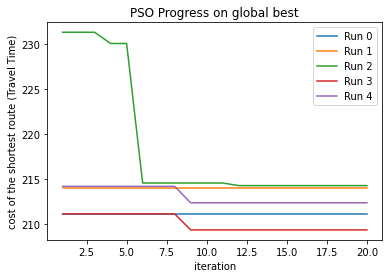

In [329]:
# the progress of global best across several runs
legend_text = list()
for i in range(len(PSO_global_states_time)):
    legend_text.append('Run ' + str(i))

plot_iteration_states(PSO_global_states_time, legend_text, 'iteration',
                      'cost of the shortest route (Travel Time)', 'PSO Progress on global best')

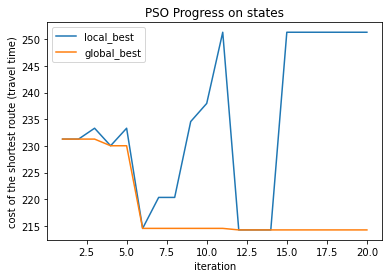

In [331]:
# the progress of the cost from both local and global best
plot_iteration_states([PSO_local_states_time[2], PSO_global_states_time[2]], ['local_best', 'global_best'], 'iteration', 'cost of the shortest route (travel time)', 'PSO Progress on states')

100%|██████████| 5/5 [00:00<00:00, 17878.53it/s]


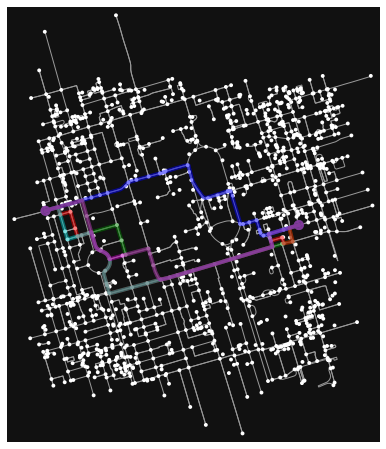

In [332]:
plot_routes(G2, PSO_global_best_route_time)

#### Case 3: combine both `Distance` and `Travel Time`

collect all the local best on each iteration and plot pareto frontier

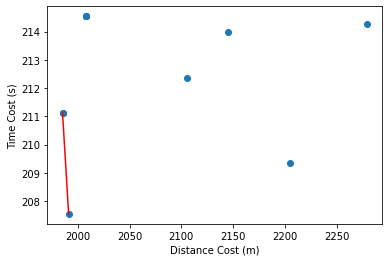

In [340]:
# get frontier
PSO_route_candidates = PSO_global_best_route_dist + PSO_global_best_route_time
PSO_routes_dist, PSO_routes_time, PSO_frontiers = process_pareto(G2, PSO_route_candidates)

# plot frontier
plot_pareto_frontier(PSO_routes_dist, PSO_routes_time, PSO_frontiers)

100%|██████████| 3/3 [00:00<00:00, 20526.77it/s]


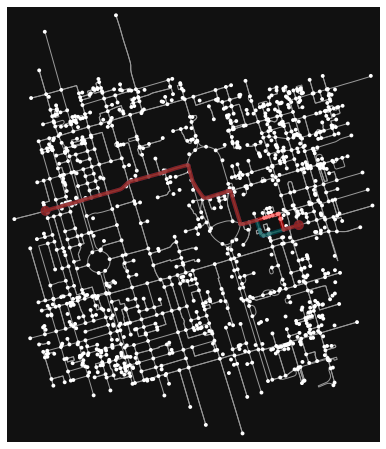

In [341]:
# display best solutions
PSO_frontier_routes = list()

for front in PSO_frontiers:
    PSO_frontier_routes.append(PSO_route_candidates[front[0]])

plot_routes(G2, PSO_frontier_routes)

## Compare GA and PSO (Adaptive version)

### 1. Get unique routes from frontiers

In [342]:
def is_in_list(target_list, source):
    for item in target_list:
        if item[1] == source[1] and item[2] == source[2]:
            return True
    return False

In [343]:
GA_unique = list()

for item in GA_frontiers:
    if not is_in_list(GA_unique, item):
        GA_unique.append(item)

len(GA_unique)

4

In [344]:
PSO_unique = list()

for item in PSO_frontiers:
    if not is_in_list(PSO_unique, item):
        PSO_unique.append(item)

len(PSO_unique)

2

### 2. Normalize the best solution from both GA and PSO (Min-Max)

In [394]:
import pandas as pd 

costs_dist = list()
costs_time = list()
algos = list()

for item in GA_unique:
    costs_dist.append(item[1])
    costs_time.append(item[2])
    algos.append('GA')

for item in PSO_unique:
    costs_dist.append(item[1])
    costs_time.append(item[2])
    algos.append('PSO')

df = pd.DataFrame(zip(algos, costs_dist, costs_time),columns=['Bio-Algo','Cost-Dist','Cost-Time'])

In [395]:
df.sort_values(by=['Cost-Dist'])

,Bio-Algo,Cost-Dist,Cost-Time
0,GA,1985.237986,211.113726
4,PSO,1985.237986,211.113726
1,GA,1991.122986,207.544416
5,PSO,1991.122986,207.544416
2,GA,2114.969036,201.317054
3,GA,2120.205980,197.457746


In [397]:
df.sort_values(by=['Cost-Time'])

,Bio-Algo,Cost-Dist,Cost-Time
3,GA,2120.205980,197.457746
2,GA,2114.969036,201.317054
1,GA,1991.122986,207.544416
5,PSO,1991.122986,207.544416
0,GA,1985.237986,211.113726
4,PSO,1985.237986,211.113726


In [346]:
# use min-max normalization
norm_df = df
norm_df['Cost-Dist'] = (norm_df['Cost-Dist']-norm_df['Cost-Dist'].min()+1)/(norm_df['Cost-Dist'].max()-norm_df['Cost-Dist'].min()+1)
norm_df['Cost-Time'] = (norm_df['Cost-Time']-norm_df['Cost-Time'].min()+1)/(norm_df['Cost-Time'].max()-norm_df['Cost-Time'].min()+1)

# apply overall cost by Cost-Dist + Cost-Time
norm_df['Cost-All'] = norm_df['Cost-Dist'] + norm_df['Cost-Time']
norm_df

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
0,GA,0.007355,1.000000,1.007355
1,GA,0.050637,0.756460,0.807097
2,GA,0.961484,0.331558,1.293042
3,GA,1.000000,0.068232,1.068232
4,PSO,0.007355,1.000000,1.007355
5,PSO,0.050637,0.756460,0.807097


### 3. Plot best solutions from both GA and PSO

- GA in blue
- PSO in orange

In [385]:
from matplotlib.lines import Line2D

def plot_best(df, key, title, xlabel = "route index", ylabel = "Normalized cost"):
    # sort by key
    sorted_df = df.sort_values(by=[key])
    
    colors =['C0' if sorted_df['Bio-Algo'][ind]=='GA' else 'C1' for ind in sorted_df.index]
    ax = sorted_df[key].plot.bar(color=colors, legend=False, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    legend_elements = [Line2D([0], [0], color='C0', lw=4, label='Adaptive version of GA'),
                       Line2D([0], [0], color='C1', lw=4, label='Adaptive version of PSO')]
    ax.legend(handles=legend_elements, loc='upper left')

In [386]:
norm_df.sort_values(by=['Cost-Dist'])

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
0,GA,0.007355,1.000000,1.007355
4,PSO,0.007355,1.000000,1.007355
1,GA,0.050637,0.756460,0.807097
5,PSO,0.050637,0.756460,0.807097
2,GA,0.961484,0.331558,1.293042
3,GA,1.000000,0.068232,1.068232


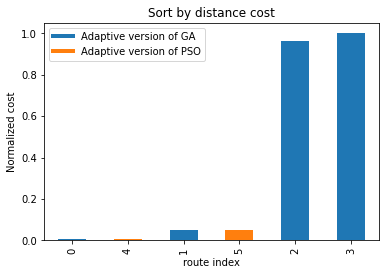

In [387]:
# sort by distance
plot_best(norm_df, 'Cost-Dist', "Sort by distance cost")

In [388]:
norm_df.sort_values(by=['Cost-Time'])

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
3,GA,1.000000,0.068232,1.068232
2,GA,0.961484,0.331558,1.293042
1,GA,0.050637,0.756460,0.807097
5,PSO,0.050637,0.756460,0.807097
0,GA,0.007355,1.000000,1.007355
4,PSO,0.007355,1.000000,1.007355


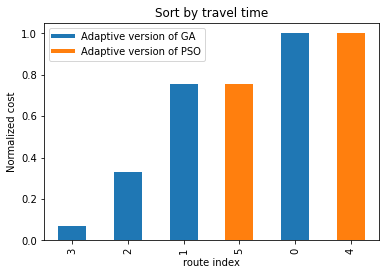

In [389]:
# sort by travel time
plot_best(norm_df, 'Cost-Time', "Sort by travel time")

In [390]:
norm_df.sort_values(by=['Cost-All'])

,Bio-Algo,Cost-Dist,Cost-Time,Cost-All
1,GA,0.050637,0.756460,0.807097
5,PSO,0.050637,0.756460,0.807097
0,GA,0.007355,1.000000,1.007355
4,PSO,0.007355,1.000000,1.007355
3,GA,1.000000,0.068232,1.068232
2,GA,0.961484,0.331558,1.293042


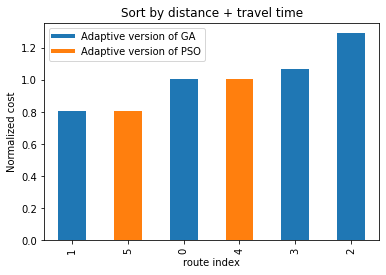

In [391]:
# sort by overall cost
plot_best(norm_df, 'Cost-All', "Sort by distance + travel time")

### 4. Box plot on both GA and PSO

In [416]:
def form_global_best_df(org_list, target_list):
    for item in org_list:
        target_list.append(item[-1])

In [417]:
GA_dist = list()
GA_time = list()
PSO_dist = list()
PSO_time = list()

form_global_best_df(GA_global_states_dist, GA_dist)
form_global_best_df(GA_global_states_time, GA_time)
form_global_best_df(PSO_global_states_dist, PSO_dist)
form_global_best_df(PSO_global_states_time, PSO_time)

df_global_best_dist = pd.DataFrame(zip(GA_dist, PSO_dist), columns=['GA-Dist','PSO-Dist'])
df_global_best_time = pd.DataFrame(zip(GA_time, PSO_time), columns=['GA-Time','PSO-Time'])

<AxesSubplot:title={'center':'Mean global best on both GA and PSO (Distance)'}>

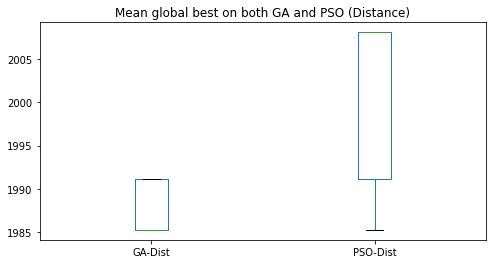

In [421]:
df_global_best_dist.plot.box(title="Mean global best on both GA and PSO (Distance)", figsize=(8,4))

<AxesSubplot:title={'center':'Mean global best on both GA and PSO (Travel Time)'}>

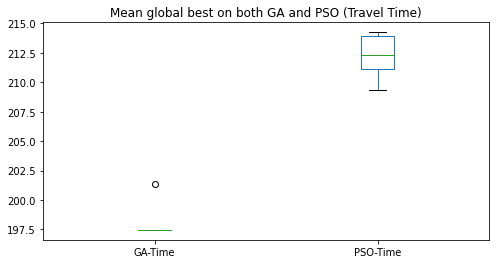

In [422]:
df_global_best_time.plot.box(title="Mean global best on both GA and PSO (Travel Time)", figsize=(8,4))

### Explore PSO with different parameters

In [96]:
PSO_local_states_param = list()
PSO_global_states_param = list()

__Run #1: particles_swarm = 45, num_of_swarms = 3, num_of_iterations = 40__

In [109]:
local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True, 45, 3, 40)
    
PSO_local_states_param.append(local_states)
PSO_global_states_param.append(global_states)

100%|██████████| 40/40 [20:39<00:00, 30.99s/it]


__Run #2: particles_swarm = 30, num_of_swarms = 5, num_of_iterations = 40__

In [104]:
local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True, 30, 5, 40)
    
PSO_local_states_param.append(local_states)
PSO_global_states_param.append(global_states)

100%|██████████| 40/40 [11:19<00:00, 16.98s/it]


__Run #3: particles_swarm = 15, num_of_swarms = 3, num_of_iterations = 50__

In [99]:
local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True, 15, 3, 50)
    
PSO_local_states_param.append(local_states)
PSO_global_states_param.append(global_states)

100%|██████████| 50/50 [17:30<00:00, 21.02s/it]


__Run #4: particles_swarm = 20, num_of_swarms = 4, num_of_iterations = 40__

In [105]:
local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True, 20, 4, 40)
    
PSO_local_states_param.append(local_states)
PSO_global_states_param.append(global_states)

100%|██████████| 40/40 [08:15<00:00, 12.38s/it]


__Run #5: particles_swarm = 45, num_of_swarms = 5, num_of_iterations = 40__

In [101]:
local_best_routes, global_best_route, local_states, global_states = pso(
        G2, cost_with_constraints, [1, 0.1, 0.5], ['length', 'num_traffic_signals', 'num_bus_stop'], [1, 1, 1], True, 45, 5, 40)
    
PSO_local_states_param.append(local_states)
PSO_global_states_param.append(global_states)

100%|██████████| 40/40 [36:54<00:00, 55.36s/it]


__Plot 5 runs below:__

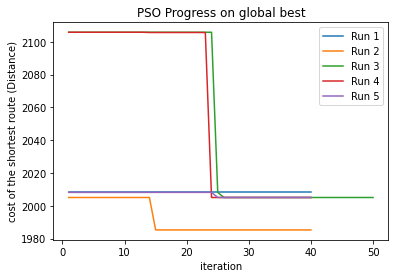

In [112]:
# the progress of global best with different parameters
legend_text = list()
for i in range(len(PSO_global_states_param)):
    legend_text.append('Run ' + str(i+1))

plot_iteration_states(PSO_global_states_param, legend_text, 'iteration',
                      'cost of the shortest route (Distance)', 'PSO Progress on global best')

In [119]:
i = 1
for param in PSO_global_states_param:
    print("global_best[ Run",i,"] =", param[-1])
    i = i + 1

global_best[ Run 1 ] = 2008.1304256870178
global_best[ Run 2 ] = 1985.2379855522115
global_best[ Run 3 ] = 2005.017425687018
global_best[ Run 4 ] = 2005.017425687018
global_best[ Run 5 ] = 2005.017425687018


In [123]:
i = 1
for param in PSO_global_states_param:
    best_cost = param[-1]
    j = len(param)
    for cost in param[::-1]:
        if cost != best_cost:
            print("converge_iteration[ Run",i,"] =", j)
            break
        j = j - 1
        
    i = i + 1

converge_iteration[ Run 1 ] = 1
converge_iteration[ Run 2 ] = 15
converge_iteration[ Run 3 ] = 26
converge_iteration[ Run 4 ] = 24
converge_iteration[ Run 5 ] = 25
